In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# !rm -rf mmsegmentation
# !git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
# !pip install -e .

/home/esbg-lab/Desktop/P3/mmsegmentation


In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

import os.path as osp
import numpy as np
from PIL import Image

import mmcv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

1.5.1+cu101 True
0.12.0


In [4]:
!mkdir checkpoints
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r101-d8_512x512_40k_voc12aug/pspnet_r101-d8_512x512_40k_voc12aug_20200613_161222-bc933b18.pth -P checkpoints

mkdir: cannot create directory 'checkpoints': File exists


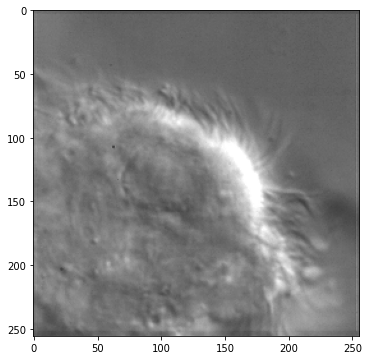

In [5]:
img = mmcv.imread('../data/my_dataset/img_dir/train/007f736aedbc4ca67989f8ca62f1bbeb447ad76698351fe387923963ee50e5ae_frame0000.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [6]:
# convert dataset annotation to semantic segmentation map
data_root = '../data/my_dataset'
img_dir = 'img_dir/train'
ann_dir = 'ann_dir/train'
# define class and plaette for better visualization
classes = ('background', 'cell', 'cilia')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125]]

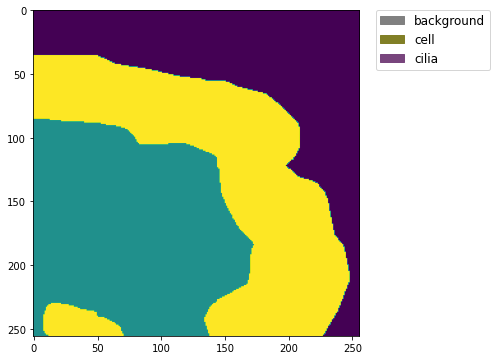

In [7]:
img = Image.open('../data/my_dataset/ann_dir/train/007f736aedbc4ca67989f8ca62f1bbeb447ad76698351fe387923963ee50e5ae_frame0000.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(3)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [8]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]

In [9]:
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [10]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class CiliaDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [11]:
from mmcv import Config
cfg = Config.fromfile('./configs/pspnet/pspnet_r101-d8_512x512_40k_voc12aug.py')

In [12]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes = 3

# Modify dataset type and path
cfg.dataset_type = 'CiliaDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 16
cfg.data.workers_per_gpu=16

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = './checkpoints/pspnet_r101-d8_512x512_40k_voc12aug_20200613_161222-bc933b18.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 5000
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input

In [13]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/home/esbg-lab/anaconda3/envs/GT/lib/python3.7/site-packages/mmcv/utils/misc.py:304: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-04-20 09:49:34,554 - mmseg - INFO - Loaded 16880 images
2021-04-20 09:49:35,163 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-04-20 09:49:37,132 - mmseg - INFO - Loaded 4220 images
2021-04-20 09:49:37,133 - mmseg - INFO - load checkpoint from ./checkpoints/pspnet_r101-d8_512x512_40k_voc12aug_20200613_161222-bc933b18.pth
2021-04-20 09:49:37,343 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) fr

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 37.0 task/s, elapsed: 114s, ETA:     0s

2021-04-20 09:53:54,983 - mmseg - INFO - per class results:
2021-04-20 09:53:54,984 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 90.66 | 94.96 |
| cell       | 83.35 | 92.23 |
| cilia      | 46.17 | 59.94 |
+------------+-------+-------+
2021-04-20 09:53:54,984 - mmseg - INFO - Summary:
2021-04-20 09:53:54,985 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 73.39 | 82.38 | 91.36 |
+--------+-------+-------+-------+
2021-04-20 09:53:54,992 - mmseg - INFO - Iter(val) [200]	mIoU: 0.7339, mAcc: 0.8238, aAcc: 0.9136, IoU.background: 0.9066, IoU.cell: 0.8335, IoU.cilia: 0.4617, Acc.background: 0.9496, Acc.cell: 0.9223, Acc.cilia: 0.5994
2021-04-20 09:54:01,224 - mmseg - INFO - Iter [210/5000]	lr: 9.627e-03, eta: 1:37:24, time: 13.801, data_time: 13.182, memory: 9591, decode.loss_seg: 0.2177, decode.acc_seg: 78.0530, aux.loss_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.6 task/s, elapsed: 115s, ETA:     0s

2021-04-20 09:58:14,935 - mmseg - INFO - per class results:
2021-04-20 09:58:14,936 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 93.71 | 96.87 |
| cell       | 87.78 | 95.43 |
| cilia      | 53.84 | 63.08 |
+------------+-------+-------+
2021-04-20 09:58:14,937 - mmseg - INFO - Summary:
2021-04-20 09:58:14,937 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 78.44 | 85.13 | 93.79 |
+--------+-------+-------+-------+
2021-04-20 09:58:14,944 - mmseg - INFO - Iter(val) [400]	mIoU: 0.7844, mAcc: 0.8513, aAcc: 0.9379, IoU.background: 0.9371, IoU.cell: 0.8778, IoU.cilia: 0.5384, Acc.background: 0.9687, Acc.cell: 0.9543, Acc.cilia: 0.6308
2021-04-20 09:58:21,176 - mmseg - INFO - Iter [410/5000]	lr: 9.268e-03, eta: 1:35:01, time: 13.983, data_time: 13.364, memory: 9591, decode.loss_seg: 0.1717, decode.acc_seg: 78.3204, aux.loss_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.4 task/s, elapsed: 116s, ETA:     0s

2021-04-20 10:02:34,797 - mmseg - INFO - per class results:
2021-04-20 10:02:34,798 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 94.52 | 97.16 |
| cell       | 89.78 | 95.18 |
| cilia      | 60.88 | 73.89 |
+------------+-------+-------+
2021-04-20 10:02:34,798 - mmseg - INFO - Summary:
2021-04-20 10:02:34,799 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 81.73 | 88.74 | 94.71 |
+--------+-------+-------+-------+
2021-04-20 10:02:34,806 - mmseg - INFO - Iter(val) [600]	mIoU: 0.8173, mAcc: 0.8874, aAcc: 0.9471, IoU.background: 0.9452, IoU.cell: 0.8978, IoU.cilia: 0.6088, Acc.background: 0.9716, Acc.cell: 0.9518, Acc.cilia: 0.7389
2021-04-20 10:02:41,050 - mmseg - INFO - Iter [610/5000]	lr: 8.908e-03, eta: 1:31:25, time: 13.981, data_time: 13.361, memory: 9591, decode.loss_seg: 0.1592, decode.acc_seg: 80.5780, aux.loss_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.1 task/s, elapsed: 117s, ETA:     0s

2021-04-20 10:06:55,682 - mmseg - INFO - per class results:
2021-04-20 10:06:55,682 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 95.0  | 97.61 |
| cell       | 90.84 | 95.29 |
| cilia      | 64.23 | 76.85 |
+------------+-------+-------+
2021-04-20 10:06:55,683 - mmseg - INFO - Summary:
2021-04-20 10:06:55,683 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 83.36 | 89.92 | 95.24 |
+--------+-------+-------+-------+
2021-04-20 10:06:55,690 - mmseg - INFO - Iter(val) [800]	mIoU: 0.8336, mAcc: 0.8992, aAcc: 0.9524, IoU.background: 0.9500, IoU.cell: 0.9084, IoU.cilia: 0.6423, Acc.background: 0.9761, Acc.cell: 0.9529, Acc.cilia: 0.7685
2021-04-20 10:07:01,944 - mmseg - INFO - Iter [810/5000]	lr: 8.546e-03, eta: 1:27:37, time: 14.077, data_time: 13.456, memory: 9591, decode.loss_seg: 0.1271, decode.acc_seg: 81.7976, aux.loss_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.2 task/s, elapsed: 117s, ETA:     0s

2021-04-20 10:11:16,459 - mmseg - INFO - per class results:
2021-04-20 10:11:16,460 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 95.8  | 97.78 |
| cell       | 92.16 | 96.6  |
| cilia      | 67.28 | 78.42 |
+------------+-------+-------+
2021-04-20 10:11:16,461 - mmseg - INFO - Summary:
2021-04-20 10:11:16,461 - mmseg - INFO - 
+--------+-------+-------+------+
| Scope  | mIoU  | mAcc  | aAcc |
+--------+-------+-------+------+
| global | 85.08 | 90.93 | 95.9 |
+--------+-------+-------+------+
2021-04-20 10:11:16,468 - mmseg - INFO - Iter(val) [1000]	mIoU: 0.8508, mAcc: 0.9093, aAcc: 0.9590, IoU.background: 0.9580, IoU.cell: 0.9216, IoU.cilia: 0.6728, Acc.background: 0.9778, Acc.cell: 0.9660, Acc.cilia: 0.7842
2021-04-20 10:11:22,721 - mmseg - INFO - Iter [1010/5000]	lr: 8.182e-03, eta: 1:23:37, time: 14.060, data_time: 13.439, memory: 9591, decode.loss_seg: 0.1170, decode.acc_seg: 81.3333, aux.loss_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.3 task/s, elapsed: 116s, ETA:     0s

2021-04-20 10:15:39,014 - mmseg - INFO - per class results:
2021-04-20 10:15:39,015 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 96.0  | 97.95 |
| cell       | 92.57 | 96.67 |
| cilia      | 68.5  | 79.42 |
+------------+-------+-------+
2021-04-20 10:15:39,015 - mmseg - INFO - Summary:
2021-04-20 10:15:39,016 - mmseg - INFO - 
+--------+-------+-------+------+
| Scope  | mIoU  | mAcc  | aAcc |
+--------+-------+-------+------+
| global | 85.69 | 91.35 | 96.1 |
+--------+-------+-------+------+
2021-04-20 10:15:39,023 - mmseg - INFO - Iter(val) [1200]	mIoU: 0.8569, mAcc: 0.9135, aAcc: 0.9610, IoU.background: 0.9600, IoU.cell: 0.9257, IoU.cilia: 0.6850, Acc.background: 0.9795, Acc.cell: 0.9667, Acc.cilia: 0.7942
2021-04-20 10:15:45,263 - mmseg - INFO - Iter [1210/5000]	lr: 7.817e-03, eta: 1:19:38, time: 14.024, data_time: 13.404, memory: 9591, decode.loss_seg: 0.1084, decode.acc_seg: 81.6272, aux.loss_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.3 task/s, elapsed: 116s, ETA:     0s

2021-04-20 10:19:59,434 - mmseg - INFO - per class results:
2021-04-20 10:19:59,435 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 96.3  | 97.88 |
| cell       | 93.05 | 97.07 |
| cilia      | 70.86 | 81.99 |
+------------+-------+-------+
2021-04-20 10:19:59,435 - mmseg - INFO - Summary:
2021-04-20 10:19:59,435 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 86.73 | 92.31 | 96.39 |
+--------+-------+-------+-------+
2021-04-20 10:19:59,442 - mmseg - INFO - Iter(val) [1400]	mIoU: 0.8673, mAcc: 0.9231, aAcc: 0.9639, IoU.background: 0.9630, IoU.cell: 0.9305, IoU.cilia: 0.7086, Acc.background: 0.9788, Acc.cell: 0.9707, Acc.cilia: 0.8199
2021-04-20 10:20:05,675 - mmseg - INFO - Iter [1410/5000]	lr: 7.449e-03, eta: 1:15:29, time: 14.034, data_time: 13.414, memory: 9591, decode.loss_seg: 0.0871, decode.acc_seg: 80.9816, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.4 task/s, elapsed: 116s, ETA:     0s

2021-04-20 10:24:19,419 - mmseg - INFO - per class results:
2021-04-20 10:24:19,420 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 96.44 | 98.12 |
| cell       | 93.58 | 97.59 |
| cilia      | 71.98 | 80.79 |
+------------+-------+-------+
2021-04-20 10:24:19,420 - mmseg - INFO - Summary:
2021-04-20 10:24:19,421 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 87.33 | 92.17 | 96.61 |
+--------+-------+-------+-------+
2021-04-20 10:24:19,428 - mmseg - INFO - Iter(val) [1600]	mIoU: 0.8733, mAcc: 0.9217, aAcc: 0.9661, IoU.background: 0.9644, IoU.cell: 0.9358, IoU.cilia: 0.7198, Acc.background: 0.9812, Acc.cell: 0.9759, Acc.cilia: 0.8079
2021-04-20 10:24:25,662 - mmseg - INFO - Iter [1610/5000]	lr: 7.080e-03, eta: 1:11:19, time: 13.989, data_time: 13.370, memory: 9591, decode.loss_seg: 0.0942, decode.acc_seg: 82.4956, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.3 task/s, elapsed: 116s, ETA:     0s

2021-04-20 10:28:39,759 - mmseg - INFO - per class results:
2021-04-20 10:28:39,760 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 96.8  | 98.47 |
| cell       | 94.18 | 96.91 |
| cilia      | 74.6  | 85.15 |
+------------+-------+-------+
2021-04-20 10:28:39,760 - mmseg - INFO - Summary:
2021-04-20 10:28:39,761 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 88.53 | 93.51 | 96.93 |
+--------+-------+-------+-------+
2021-04-20 10:28:39,768 - mmseg - INFO - Iter(val) [1800]	mIoU: 0.8853, mAcc: 0.9351, aAcc: 0.9693, IoU.background: 0.9680, IoU.cell: 0.9418, IoU.cilia: 0.7460, Acc.background: 0.9847, Acc.cell: 0.9691, Acc.cilia: 0.8515
2021-04-20 10:28:46,002 - mmseg - INFO - Iter [1810/5000]	lr: 6.708e-03, eta: 1:07:08, time: 14.017, data_time: 13.398, memory: 9591, decode.loss_seg: 0.0817, decode.acc_seg: 83.7486, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.7 task/s, elapsed: 115s, ETA:     0s

2021-04-20 10:32:58,931 - mmseg - INFO - per class results:
2021-04-20 10:32:58,931 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 96.81 | 98.0  |
| cell       | 94.51 | 97.17 |
| cilia      | 76.14 | 89.02 |
+------------+-------+-------+
2021-04-20 10:32:58,932 - mmseg - INFO - Summary:
2021-04-20 10:32:58,932 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 89.15 | 94.73 | 97.04 |
+--------+-------+-------+-------+
2021-04-20 10:32:58,939 - mmseg - INFO - Iter(val) [2000]	mIoU: 0.8915, mAcc: 0.9473, aAcc: 0.9704, IoU.background: 0.9681, IoU.cell: 0.9451, IoU.cilia: 0.7614, Acc.background: 0.9800, Acc.cell: 0.9717, Acc.cilia: 0.8902
2021-04-20 10:33:05,171 - mmseg - INFO - Iter [2010/5000]	lr: 6.334e-03, eta: 1:02:55, time: 13.900, data_time: 13.281, memory: 9591, decode.loss_seg: 0.0752, decode.acc_seg: 78.8664, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.1 task/s, elapsed: 117s, ETA:     0s

2021-04-20 10:37:22,205 - mmseg - INFO - per class results:
2021-04-20 10:37:22,206 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.07 | 98.46 |
| cell       | 94.81 | 97.75 |
| cilia      | 76.76 | 85.61 |
+------------+-------+-------+
2021-04-20 10:37:22,206 - mmseg - INFO - Summary:
2021-04-20 10:37:22,207 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 89.55 | 93.94 | 97.24 |
+--------+-------+-------+-------+
2021-04-20 10:37:22,214 - mmseg - INFO - Iter(val) [2200]	mIoU: 0.8955, mAcc: 0.9394, aAcc: 0.9724, IoU.background: 0.9707, IoU.cell: 0.9481, IoU.cilia: 0.7676, Acc.background: 0.9846, Acc.cell: 0.9775, Acc.cilia: 0.8561
2021-04-20 10:37:28,454 - mmseg - INFO - Iter [2210/5000]	lr: 5.958e-03, eta: 0:58:47, time: 14.081, data_time: 13.461, memory: 9591, decode.loss_seg: 0.0689, decode.acc_seg: 82.0695, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.1 task/s, elapsed: 117s, ETA:     0s

2021-04-20 10:41:43,044 - mmseg - INFO - per class results:
2021-04-20 10:41:43,045 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.12 | 98.48 |
| cell       | 94.82 | 96.98 |
| cilia      | 77.53 | 89.16 |
+------------+-------+-------+
2021-04-20 10:41:43,045 - mmseg - INFO - Summary:
2021-04-20 10:41:43,046 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 89.82 | 94.87 | 97.26 |
+--------+-------+-------+-------+
2021-04-20 10:41:43,053 - mmseg - INFO - Iter(val) [2400]	mIoU: 0.8982, mAcc: 0.9487, aAcc: 0.9726, IoU.background: 0.9712, IoU.cell: 0.9482, IoU.cilia: 0.7753, Acc.background: 0.9848, Acc.cell: 0.9698, Acc.cilia: 0.8916
2021-04-20 10:41:49,314 - mmseg - INFO - Iter [2410/5000]	lr: 5.579e-03, eta: 0:54:35, time: 14.075, data_time: 13.453, memory: 9591, decode.loss_seg: 0.0682, decode.acc_seg: 82.2094, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.5 task/s, elapsed: 116s, ETA:     0s

2021-04-20 10:46:02,749 - mmseg - INFO - per class results:
2021-04-20 10:46:02,750 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.24 | 98.45 |
| cell       | 95.17 | 97.81 |
| cilia      | 78.45 | 87.84 |
+------------+-------+-------+
2021-04-20 10:46:02,751 - mmseg - INFO - Summary:
2021-04-20 10:46:02,751 - mmseg - INFO - 
+--------+-------+------+-------+
| Scope  | mIoU  | mAcc | aAcc  |
+--------+-------+------+-------+
| global | 90.29 | 94.7 | 97.42 |
+--------+-------+------+-------+
2021-04-20 10:46:02,758 - mmseg - INFO - Iter(val) [2600]	mIoU: 0.9029, mAcc: 0.9470, aAcc: 0.9742, IoU.background: 0.9724, IoU.cell: 0.9517, IoU.cilia: 0.7845, Acc.background: 0.9845, Acc.cell: 0.9781, Acc.cilia: 0.8784
2021-04-20 10:46:08,987 - mmseg - INFO - Iter [2610/5000]	lr: 5.197e-03, eta: 0:50:22, time: 13.963, data_time: 13.344, memory: 9591, decode.loss_seg: 0.0625, decode.acc_seg: 82.5392, aux.loss_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.4 task/s, elapsed: 116s, ETA:     0s

2021-04-20 10:50:22,727 - mmseg - INFO - per class results:
2021-04-20 10:50:22,728 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.2  | 98.47 |
| cell       | 95.29 | 97.55 |
| cilia      | 78.97 | 89.19 |
+------------+-------+-------+
2021-04-20 10:50:22,728 - mmseg - INFO - Summary:
2021-04-20 10:50:22,729 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 90.48 | 95.07 | 97.45 |
+--------+-------+-------+-------+
2021-04-20 10:50:22,735 - mmseg - INFO - Iter(val) [2800]	mIoU: 0.9048, mAcc: 0.9507, aAcc: 0.9745, IoU.background: 0.9720, IoU.cell: 0.9529, IoU.cilia: 0.7897, Acc.background: 0.9847, Acc.cell: 0.9755, Acc.cilia: 0.8919
2021-04-20 10:50:28,995 - mmseg - INFO - Iter [2810/5000]	lr: 4.811e-03, eta: 0:46:09, time: 13.985, data_time: 13.363, memory: 9591, decode.loss_seg: 0.0663, decode.acc_seg: 81.2417, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.3 task/s, elapsed: 116s, ETA:     0s

2021-04-20 10:54:43,082 - mmseg - INFO - per class results:
2021-04-20 10:54:43,083 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.33 | 98.55 |
| cell       | 95.35 | 97.8  |
| cilia      | 79.29 | 88.44 |
+------------+-------+-------+
2021-04-20 10:54:43,083 - mmseg - INFO - Summary:
2021-04-20 10:54:43,084 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 90.66 | 94.93 | 97.52 |
+--------+-------+-------+-------+
2021-04-20 10:54:43,091 - mmseg - INFO - Iter(val) [3000]	mIoU: 0.9066, mAcc: 0.9493, aAcc: 0.9752, IoU.background: 0.9733, IoU.cell: 0.9535, IoU.cilia: 0.7929, Acc.background: 0.9855, Acc.cell: 0.9780, Acc.cilia: 0.8844
2021-04-20 10:54:49,343 - mmseg - INFO - Iter [3010/5000]	lr: 4.422e-03, eta: 0:41:57, time: 14.019, data_time: 13.398, memory: 9591, decode.loss_seg: 0.0523, decode.acc_seg: 80.2109, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 35.8 task/s, elapsed: 118s, ETA:     0s

2021-04-20 10:59:07,490 - mmseg - INFO - per class results:
2021-04-20 10:59:07,491 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.45 | 98.56 |
| cell       | 95.55 | 97.59 |
| cilia      | 80.34 | 90.66 |
+------------+-------+-------+
2021-04-20 10:59:07,491 - mmseg - INFO - Summary:
2021-04-20 10:59:07,492 - mmseg - INFO - 
+--------+-------+------+-------+
| Scope  | mIoU  | mAcc | aAcc  |
+--------+-------+------+-------+
| global | 91.11 | 95.6 | 97.63 |
+--------+-------+------+-------+
2021-04-20 10:59:07,499 - mmseg - INFO - Iter(val) [3200]	mIoU: 0.9111, mAcc: 0.9560, aAcc: 0.9763, IoU.background: 0.9745, IoU.cell: 0.9555, IoU.cilia: 0.8034, Acc.background: 0.9856, Acc.cell: 0.9759, Acc.cilia: 0.9066
2021-04-20 10:59:13,744 - mmseg - INFO - Iter [3210/5000]	lr: 4.030e-03, eta: 0:37:46, time: 14.212, data_time: 13.591, memory: 9591, decode.loss_seg: 0.0616, decode.acc_seg: 83.3149, aux.loss_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.3 task/s, elapsed: 116s, ETA:     0s

2021-04-20 11:03:27,599 - mmseg - INFO - per class results:
2021-04-20 11:03:27,600 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.5  | 98.65 |
| cell       | 95.68 | 97.89 |
| cilia      | 80.79 | 89.56 |
+------------+-------+-------+
2021-04-20 11:03:27,600 - mmseg - INFO - Summary:
2021-04-20 11:03:27,600 - mmseg - INFO - 
+--------+-------+-------+------+
| Scope  | mIoU  | mAcc  | aAcc |
+--------+-------+-------+------+
| global | 91.32 | 95.37 | 97.7 |
+--------+-------+-------+------+
2021-04-20 11:03:27,607 - mmseg - INFO - Iter(val) [3400]	mIoU: 0.9132, mAcc: 0.9537, aAcc: 0.9770, IoU.background: 0.9750, IoU.cell: 0.9568, IoU.cilia: 0.8079, Acc.background: 0.9865, Acc.cell: 0.9789, Acc.cilia: 0.8956
2021-04-20 11:03:33,863 - mmseg - INFO - Iter [3410/5000]	lr: 3.632e-03, eta: 0:33:33, time: 14.030, data_time: 13.408, memory: 9591, decode.loss_seg: 0.0595, decode.acc_seg: 84.2388, aux.loss_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.4 task/s, elapsed: 116s, ETA:     0s

2021-04-20 11:07:47,425 - mmseg - INFO - per class results:
2021-04-20 11:07:47,426 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.5  | 98.48 |
| cell       | 95.8  | 97.8  |
| cilia      | 81.16 | 91.62 |
+------------+-------+-------+
2021-04-20 11:07:47,426 - mmseg - INFO - Summary:
2021-04-20 11:07:47,426 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 91.49 | 95.97 | 97.72 |
+--------+-------+-------+-------+
2021-04-20 11:07:47,434 - mmseg - INFO - Iter(val) [3600]	mIoU: 0.9149, mAcc: 0.9597, aAcc: 0.9772, IoU.background: 0.9750, IoU.cell: 0.9580, IoU.cilia: 0.8116, Acc.background: 0.9848, Acc.cell: 0.9780, Acc.cilia: 0.9162
2021-04-20 11:07:53,677 - mmseg - INFO - Iter [3610/5000]	lr: 3.230e-03, eta: 0:29:20, time: 13.994, data_time: 13.374, memory: 9591, decode.loss_seg: 0.0545, decode.acc_seg: 84.5924, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.3 task/s, elapsed: 116s, ETA:     0s

2021-04-20 11:12:07,701 - mmseg - INFO - per class results:
2021-04-20 11:12:07,702 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.52 | 98.58 |
| cell       | 95.9  | 97.91 |
| cilia      | 81.28 | 90.81 |
+------------+-------+-------+
2021-04-20 11:12:07,702 - mmseg - INFO - Summary:
2021-04-20 11:12:07,703 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 91.57 | 95.77 | 97.76 |
+--------+-------+-------+-------+
2021-04-20 11:12:07,709 - mmseg - INFO - Iter(val) [3800]	mIoU: 0.9157, mAcc: 0.9577, aAcc: 0.9776, IoU.background: 0.9752, IoU.cell: 0.9590, IoU.cilia: 0.8128, Acc.background: 0.9858, Acc.cell: 0.9791, Acc.cilia: 0.9081
2021-04-20 11:12:13,966 - mmseg - INFO - Iter [3810/5000]	lr: 2.822e-03, eta: 0:25:07, time: 14.039, data_time: 13.417, memory: 9591, decode.loss_seg: 0.0552, decode.acc_seg: 82.5868, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.3 task/s, elapsed: 116s, ETA:     0s

2021-04-20 11:16:28,011 - mmseg - INFO - per class results:
2021-04-20 11:16:28,012 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.62 | 98.65 |
| cell       | 95.97 | 98.03 |
| cilia      | 81.97 | 90.76 |
+------------+-------+-------+
2021-04-20 11:16:28,013 - mmseg - INFO - Summary:
2021-04-20 11:16:28,013 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 91.85 | 95.82 | 97.84 |
+--------+-------+-------+-------+
2021-04-20 11:16:28,020 - mmseg - INFO - Iter(val) [4000]	mIoU: 0.9185, mAcc: 0.9582, aAcc: 0.9784, IoU.background: 0.9762, IoU.cell: 0.9597, IoU.cilia: 0.8197, Acc.background: 0.9865, Acc.cell: 0.9803, Acc.cilia: 0.9076
2021-04-20 11:16:34,279 - mmseg - INFO - Iter [4010/5000]	lr: 2.407e-03, eta: 0:20:53, time: 14.037, data_time: 13.415, memory: 9591, decode.loss_seg: 0.0506, decode.acc_seg: 81.1993, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.3 task/s, elapsed: 116s, ETA:     0s

2021-04-20 11:20:48,235 - mmseg - INFO - per class results:
2021-04-20 11:20:48,236 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.62 | 98.76 |
| cell       | 95.93 | 97.64 |
| cilia      | 81.99 | 91.42 |
+------------+-------+-------+
2021-04-20 11:20:48,237 - mmseg - INFO - Summary:
2021-04-20 11:20:48,237 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 91.84 | 95.94 | 97.83 |
+--------+-------+-------+-------+
2021-04-20 11:20:48,244 - mmseg - INFO - Iter(val) [4200]	mIoU: 0.9184, mAcc: 0.9594, aAcc: 0.9783, IoU.background: 0.9762, IoU.cell: 0.9593, IoU.cilia: 0.8199, Acc.background: 0.9876, Acc.cell: 0.9764, Acc.cilia: 0.9142
2021-04-20 11:20:54,473 - mmseg - INFO - Iter [4210/5000]	lr: 1.983e-03, eta: 0:16:40, time: 14.026, data_time: 13.407, memory: 9591, decode.loss_seg: 0.0555, decode.acc_seg: 84.8768, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.4 task/s, elapsed: 116s, ETA:     0s

2021-04-20 11:25:10,382 - mmseg - INFO - per class results:
2021-04-20 11:25:10,383 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.62 | 98.61 |
| cell       | 96.03 | 97.92 |
| cilia      | 82.21 | 91.74 |
+------------+-------+-------+
2021-04-20 11:25:10,383 - mmseg - INFO - Summary:
2021-04-20 11:25:10,384 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 91.96 | 96.09 | 97.86 |
+--------+-------+-------+-------+
2021-04-20 11:25:10,391 - mmseg - INFO - Iter(val) [4400]	mIoU: 0.9196, mAcc: 0.9609, aAcc: 0.9786, IoU.background: 0.9762, IoU.cell: 0.9603, IoU.cilia: 0.8221, Acc.background: 0.9861, Acc.cell: 0.9792, Acc.cilia: 0.9174
2021-04-20 11:25:16,674 - mmseg - INFO - Iter [4410/5000]	lr: 1.549e-03, eta: 0:12:27, time: 14.006, data_time: 13.382, memory: 9591, decode.loss_seg: 0.0536, decode.acc_seg: 80.6412, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.1 task/s, elapsed: 117s, ETA:     0s

2021-04-20 11:29:31,247 - mmseg - INFO - per class results:
2021-04-20 11:29:31,248 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.66 | 98.71 |
| cell       | 96.08 | 98.08 |
| cilia      | 82.36 | 90.77 |
+------------+-------+-------+
2021-04-20 11:29:31,249 - mmseg - INFO - Summary:
2021-04-20 11:29:31,249 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 92.03 | 95.85 | 97.89 |
+--------+-------+-------+-------+
2021-04-20 11:29:31,256 - mmseg - INFO - Iter(val) [4600]	mIoU: 0.9203, mAcc: 0.9585, aAcc: 0.9789, IoU.background: 0.9766, IoU.cell: 0.9608, IoU.cilia: 0.8236, Acc.background: 0.9871, Acc.cell: 0.9808, Acc.cilia: 0.9077
2021-04-20 11:29:37,511 - mmseg - INFO - Iter [4610/5000]	lr: 1.099e-03, eta: 0:08:14, time: 14.097, data_time: 13.476, memory: 9591, decode.loss_seg: 0.0541, decode.acc_seg: 82.8898, aux.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.5 task/s, elapsed: 116s, ETA:     0s

2021-04-20 11:33:50,688 - mmseg - INFO - per class results:
2021-04-20 11:33:50,689 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.7  | 98.75 |
| cell       | 96.11 | 98.06 |
| cilia      | 82.57 | 90.89 |
+------------+-------+-------+
2021-04-20 11:33:50,689 - mmseg - INFO - Summary:
2021-04-20 11:33:50,689 - mmseg - INFO - 
+--------+-------+------+-------+
| Scope  | mIoU  | mAcc | aAcc  |
+--------+-------+------+-------+
| global | 92.13 | 95.9 | 97.92 |
+--------+-------+------+-------+
2021-04-20 11:33:50,696 - mmseg - INFO - Iter(val) [4800]	mIoU: 0.9213, mAcc: 0.9590, aAcc: 0.9792, IoU.background: 0.9770, IoU.cell: 0.9611, IoU.cilia: 0.8257, Acc.background: 0.9875, Acc.cell: 0.9806, Acc.cilia: 0.9089
2021-04-20 11:33:56,940 - mmseg - INFO - Iter [4810/5000]	lr: 6.242e-04, eta: 0:04:00, time: 13.951, data_time: 13.330, memory: 9591, decode.loss_seg: 0.0526, decode.acc_seg: 84.2828, aux.loss_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4220/4220, 36.4 task/s, elapsed: 116s, ETA:     0s

2021-04-20 11:38:10,382 - mmseg - INFO - per class results:
2021-04-20 11:38:10,383 - mmseg - INFO - 
+------------+-------+-------+
| Class      | IoU   | Acc   |
+------------+-------+-------+
| background | 97.72 | 98.72 |
| cell       | 96.15 | 98.07 |
| cilia      | 82.87 | 91.4  |
+------------+-------+-------+
2021-04-20 11:38:10,383 - mmseg - INFO - Summary:
2021-04-20 11:38:10,383 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 92.25 | 96.06 | 97.94 |
+--------+-------+-------+-------+
2021-04-20 11:38:10,390 - mmseg - INFO - Iter(val) [5000]	mIoU: 0.9225, mAcc: 0.9606, aAcc: 0.9794, IoU.background: 0.9772, IoU.cell: 0.9615, IoU.cilia: 0.8287, Acc.background: 0.9872, Acc.cell: 0.9807, Acc.cilia: 0.9140


/home/esbg-lab/Desktop/P3/mmsegmentation/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

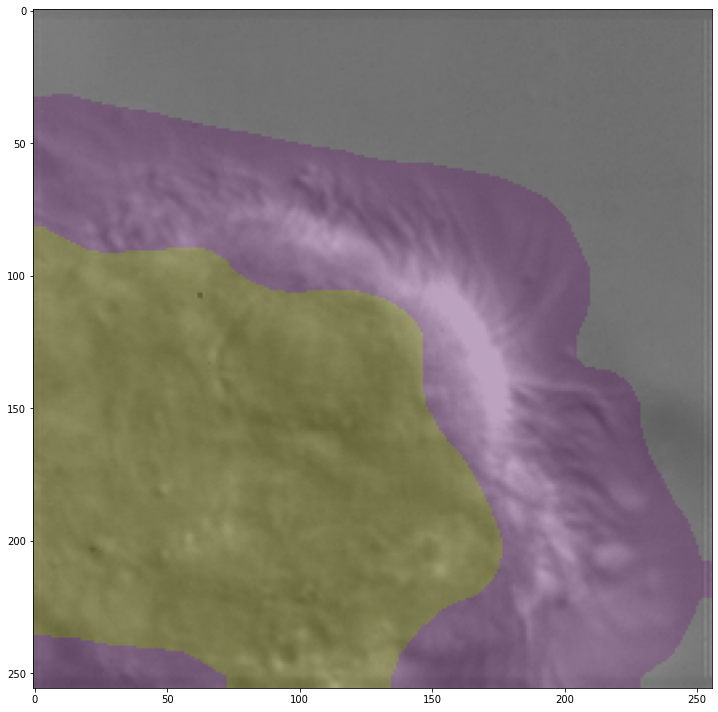

In [14]:
img = mmcv.imread('../data/my_dataset/img_dir/train/007f736aedbc4ca67989f8ca62f1bbeb447ad76698351fe387923963ee50e5ae_frame0000.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

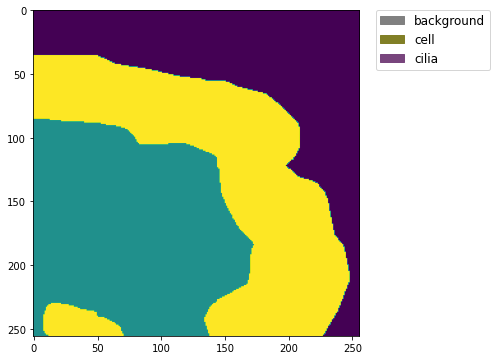

In [15]:
img = Image.open('../data/my_dataset/ann_dir/train/007f736aedbc4ca67989f8ca62f1bbeb447ad76698351fe387923963ee50e5ae_frame0000.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(3)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [16]:
import os
rootdir = '/home/esbg-lab/Desktop/P3/data/my_dataset/img_dir/test'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if str(file).split("_frame")[1]=="0000.png":
#             print(str(file).split("_frame")[0])
            img = mmcv.imread(os.path.join(subdir, file))
            result = inference_segmentor(model, img)
            im = Image.fromarray(result[0].astype(np.uint8))
            im.save("/home/esbg-lab/Desktop/P3/predictions/"+str(str(file).split("_frame")[0])+".png")
#             print(result[0].shape)
            
#         print(str(file).split("_frame")[1])
#         print(str(subdir).split("/")[-1])
#         print(img)
#         new_name = str(subdir).split("/")[-1] +"_"+ file
#         shutil.copy(os.path.join(subdir, file), "./data/my_dataset/img_dir/test/"+new_name)